<a href="https://colab.research.google.com/github/edamame1018/-competition-/blob/main/%5E%20%5Ejikken_b_cifar10_groupwork_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNによる一般画像認識（グループワーク作業用）

## このノートブックの目的
このノートブックは，グループワークの作業用です．自己学習用ノートブックは一つ一つの要素を学習するために作られていますが，このノートブックは，グループワークの作業を行うためのものです．



## Google Colabの設定

Google Colabのメニューで，「ランタイム」→「ランタイムのタイプを変更」を選び，「**ハードウエアアクセラレータ**」を「**T4 GPU**」にして保存してください．

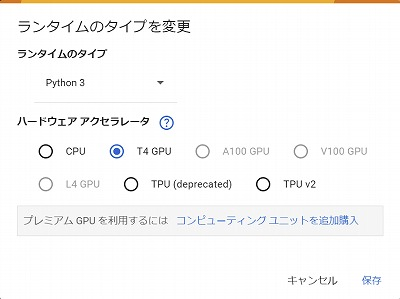

In [146]:
# Googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

# ファイルを保存するディレクトリ(フォルダ)
# ここではマイドライブにjikken_b/cifar10を作成
!mkdir -p jikken_b/cifar10
%cd jikken_b/cifar10

# Google Colab 以外で使用する場合はこのセル全体をコメントアウト(あるいは削除)してください．

In [147]:
import os
current_dir=os.getcwd()
print('\n[重要] 学習済みモデルなどのファイルは', current_dir, 'に保存されます．')


[重要] 学習済みモデルなどのファイルは /content/drive/MyDrive/jikken_b/cifar10 に保存されます．


## 班番号と重点学習クラスの番号の入力 ##

**班番号**と**重点学習クラスの番号**を選択してください．右側のプルダウンメニュー(ドロップダウンリスト)から選ぶと左側の変数に反映されます．右側にメニューが表示されない場合は，変数`GROUP_NO`と変数`CLASS_NO`の右辺に直接記述するようにしてください．重点学習クラスの番号がまだ相談できていない場合は適当に選んでもらってもかまいませんが，班で決定後に修正することを忘れないようにしてください．


In [148]:
# 要修正：班番号('文字列'で2桁)
GROUP_NO = '99' #@param ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "99"]
# 要修正：重点学習クラス番号('文字列'で1桁)
CLASS_NO = '6' #@param ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

選択後に必ず**上記のセルを実行**してください．




In [149]:
# 名前リストの定義．分類番号cの分類名をclassNames[c]とする．
classNames = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('班番号:'+ GROUP_NO)
print('重点学習クラス：' + CLASS_NO + '(' + classNames[int(CLASS_NO)] + ')')
# 学習済みCNNモデルのファイル名は以下のようになる．
LEARNED_CNN_MODEL = 'cnn-' + GROUP_NO + '-' + CLASS_NO + '.keras'
print('学習済みCNNモデル名：' + LEARNED_CNN_MODEL)

班番号:99
重点学習クラス：6(frog)
学習済みCNNモデル名：cnn-99-6.keras


実行結果に示される班番号と重点学習クラスの番号が間違っていないかよく確認してください．

## 必要モジュール読み込みとデータセットの読み込み

In [150]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# CIFAR-10データセットの取得
from keras.datasets import cifar10

# クラスラベルの1-hotエンコーディング
from keras.utils import to_categorical

# cifar10.load_data()で，データセットを読み込んで変数に代入する．
# x_train_org: 訓練用画像のデータ (4次元配列になる．最初のインデックスがデータの指定，残りの3次元が色を含めた画像データ)
# y_train_org: 訓練用画像のデータ (2次元配列になる．最初のインデックスがデータの指定，残り1次元は画像の分類番号0-9)
# x_test_org: 評価用画像のデータ (4次元配列になる．最初のインデックスがデータの指定，残りの3次元が色を含めた画像データ)
# y_test_org: 評価用画像のデータ (2次元配列になる．最初のインデックスがデータの指定，残り1次元は画像の分類番号0-9)

(x_train_org, y_train_org), (x_test_org, y_test_org) = cifar10.load_data()

# 本実験では元のデータセットを並べ替えてから利用します．
train_indices=[[0 for j in range(5000)] for i in range(10)]
test_indices=[[0 for j in range(1000)] for i in range(10)]
for i in range(10):
    train_indices[i]=[index for index in range(50000) if y_train_org[index] == i]
    test_indices[i]=[index for index in range(10000) if y_test_org[index] == i]
x_train_sorted=x_train_org.copy()
y_train_sorted=y_train_org.copy()
x_test_sorted=x_test_org.copy()
y_test_sorted=y_test_org.copy()
for i in range(5000):
    for j in range(10):
        x_train_sorted[i*10+j]=x_train_org[train_indices[j][i]]
        y_train_sorted[i*10+j]=j
for i in range(1000):
    for j in range(10):
        x_test_sorted[i*10+j]=x_test_org[test_indices[j][i]]
        y_test_sorted[i*10+j]=j
x_train_org=x_train_sorted
y_train_org=y_train_sorted
x_test_org=x_test_sorted
y_test_org=y_test_sorted

# オリジナルデータ正規化と1-hot-ベクトル化
x_train_org_norm = x_train_org/255.0
y_train_org_onehot = to_categorical(y_train_org, 10)
x_test_org_norm = x_test_org/255.0
y_test_org_onehot = to_categorical(y_test_org, 10)

## i番目の訓練用画像の表示関数

In [151]:
# x_train_orgとy_train_orgのi番目のデータの分類名と画像を表示する関数
def printDataOrg(i):
    print(classNames[y_train_org[i,0]])
    plt.figure(figsize=(2,2))
    plt.imshow(x_train_org[i])
    plt.tick_params(left=False, labelleft=False)
    plt.tick_params(bottom=False, labelbottom=False)
    plt.show()

plane


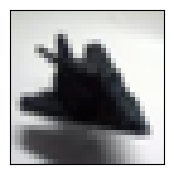

In [152]:
# 0番データの表示
printDataOrg(0)

## 訓練用画像をM*N枚まとめて表示するコード

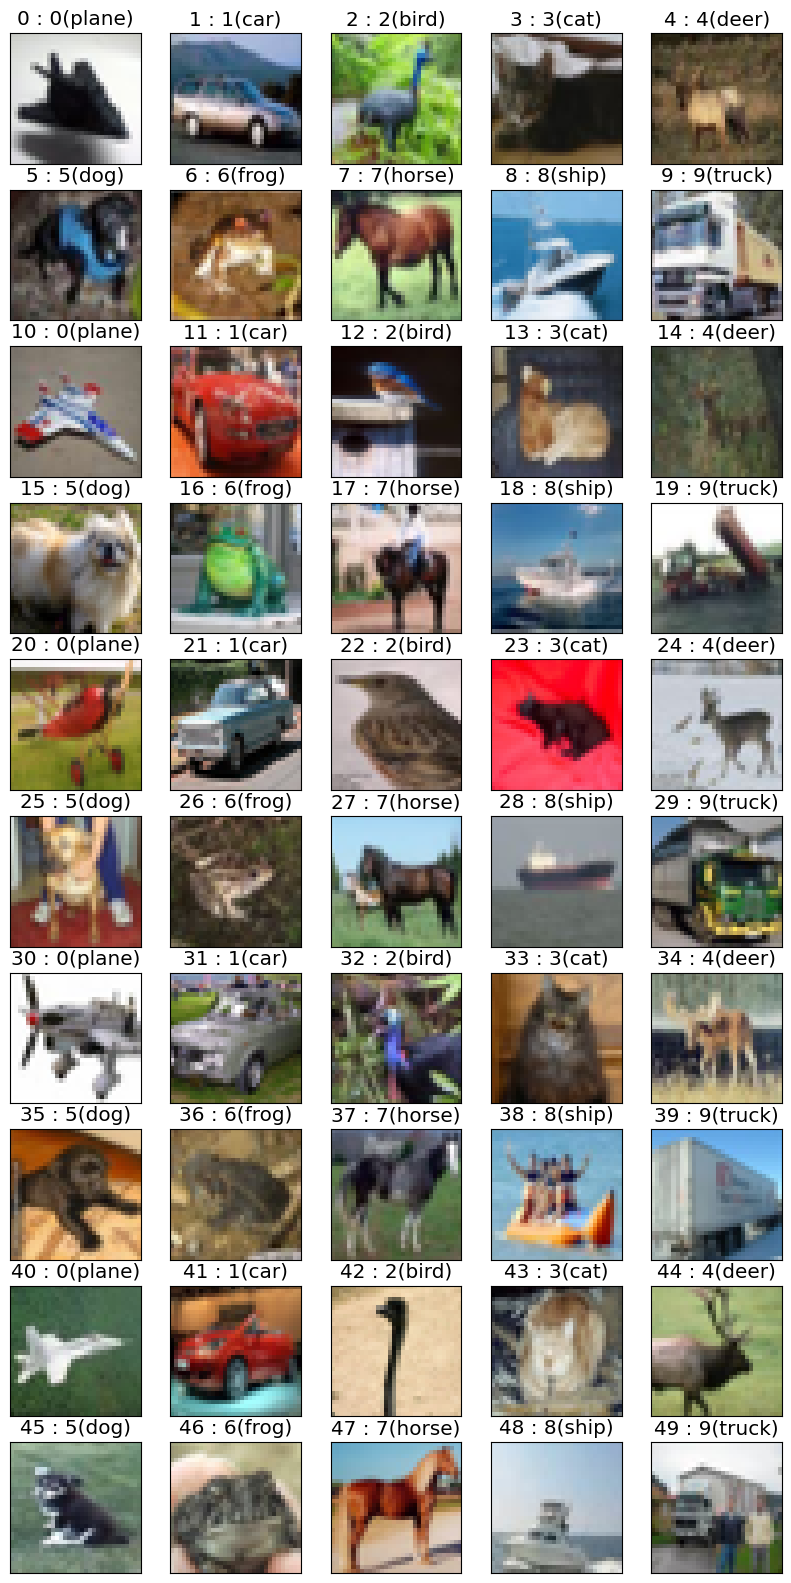

In [153]:
# M*N枚の画像を表示する
M=10 #行数
N= 5 #列数
# 表示先の画像を準備
plt.figure(figsize=(N*2,M*2))
# indexを変数としてループしながら画像を表示
for index in range(M*N):
    # index番の画像の正解分類番号
    classIdx=y_train_org[index][0]
    # index番の画像の表示位置指定
    cifar_img=plt.subplot(M,N,index+1)
    # index番画像の表示
    plt.imshow(x_train_org[index])
    # 横，下ラベルの非表示
    plt.tick_params(left=False, labelleft=False)
    plt.tick_params(bottom=False, labelbottom=False)
    # 上にindexと，正解分類番号と，正解分類名を表示
    plt.title("{} : {}({})".format(index,classIdx ,classNames[classIdx]))

# 表示命令
plt.show()

## 重点学習クラスの画像をM*N枚分表示するコード

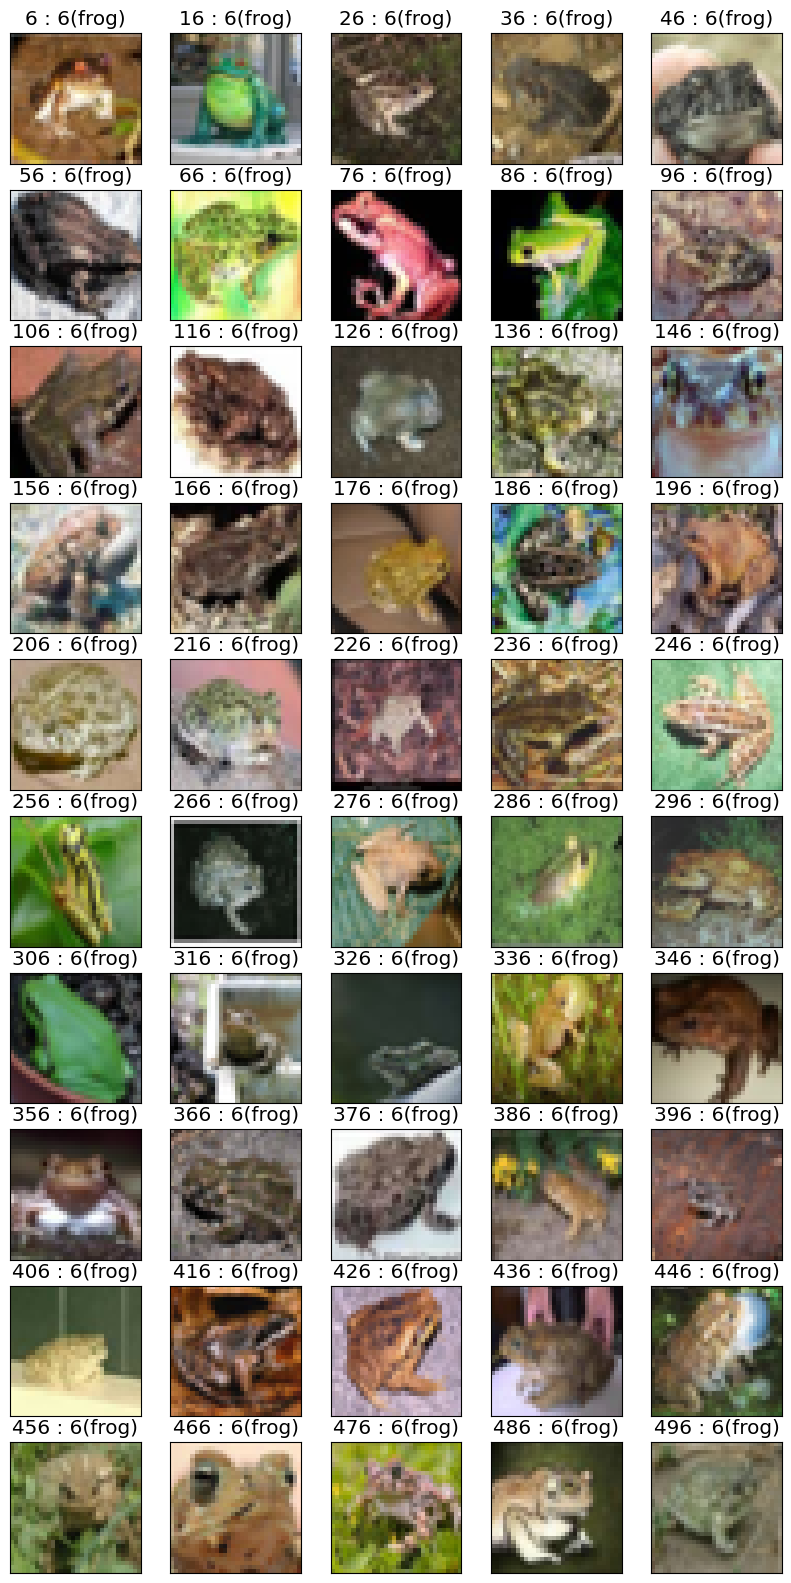

In [154]:
# M*N枚の画像を表示する
M=10 #行数
N= 5 #列数
plt.figure(figsize=(N*2,M*2))
# 表示した画像の数をカウントする
count = 0
for index in range(50000):
    classIdx=y_train_org[index][0]
    # classIdxが重点学習クラスの場合にのみ表示処理をする
    if(classIdx == int(CLASS_NO)):
        cifar_img=plt.subplot(M,N,count+1)
        plt.imshow(x_train_org[index])
        plt.tick_params(left=False, labelleft=False)
        plt.tick_params(bottom=False, labelbottom=False)
        plt.title("{} : {}({})".format(index,classIdx ,classNames[classIdx]))
        # 表示した画像の数をカウントする
        count += 1
    # 表示画像数がM*Nに達したらループを脱出
    if(count >= M*N):
        break
plt.show()

## 実験で利用するCIFAR-10データセットの範囲

CIFAR-10には，訓練用画像50000枚，評価用画像10000枚が入っています．
オリジナルデータの変数名は以下の通り．

※ この実験ではあらかじめデータを並べ替えたものを使用しています．

訓練用画像：`x_train_org`

訓練用画像の正解値：`y_train_org`

評価用画像：`x_test_org`

評価用画像の正解値：`y_train_org`




コンテストで提出する認識モデルの学習は，「訓練用画像」のオリジナルデータから，「最初の10000枚:0-9999」＋「10000-49999から1000枚まで（グループごと）」を選んで学習させます．


## CNNモデル学習における，追加学習データ選定の１例

以下のコードは，10000-49999から，正解クラスの番号が重点学習クラスの場合のデータを全て集めて，その番号をtrainDataIndex.txtに出力します．この例では4000枚の画像が抽出されています．

In [155]:
# ファイル出力用モジュール
import pickle

#分類番号0のデータを集めるリスト
myTrainDataIndexList = []

# indexを10000-49999の範囲にしてループ
for index in range(10000,50000):
    # index番データの正解分類番号
    classIdx=y_train_org[index][0]
    # 正解分類番号が重点学習クラスならリストに追加
    if(classIdx==int(CLASS_NO)):
        myTrainDataIndexList.append(index)

# リストサイズ出力
print (len(myTrainDataIndexList))
# リスト出力
print (myTrainDataIndexList)
# リストをtrainDataIndex.txtに出力
np.savetxt('trainDataIndex.txt', myTrainDataIndexList, fmt='%d')

4000
[10006, 10016, 10026, 10036, 10046, 10056, 10066, 10076, 10086, 10096, 10106, 10116, 10126, 10136, 10146, 10156, 10166, 10176, 10186, 10196, 10206, 10216, 10226, 10236, 10246, 10256, 10266, 10276, 10286, 10296, 10306, 10316, 10326, 10336, 10346, 10356, 10366, 10376, 10386, 10396, 10406, 10416, 10426, 10436, 10446, 10456, 10466, 10476, 10486, 10496, 10506, 10516, 10526, 10536, 10546, 10556, 10566, 10576, 10586, 10596, 10606, 10616, 10626, 10636, 10646, 10656, 10666, 10676, 10686, 10696, 10706, 10716, 10726, 10736, 10746, 10756, 10766, 10776, 10786, 10796, 10806, 10816, 10826, 10836, 10846, 10856, 10866, 10876, 10886, 10896, 10906, 10916, 10926, 10936, 10946, 10956, 10966, 10976, 10986, 10996, 11006, 11016, 11026, 11036, 11046, 11056, 11066, 11076, 11086, 11096, 11106, 11116, 11126, 11136, 11146, 11156, 11166, 11176, 11186, 11196, 11206, 11216, 11226, 11236, 11246, 11256, 11266, 11276, 11286, 11296, 11306, 11316, 11326, 11336, 11346, 11356, 11366, 11376, 11386, 11396, 11406, 11416, 

## ファイルに記述した追加データを含めての学習データ作成
以下のコードは，
`'trainDataIndex.txt'`に出力されたデータを，ファイルの先頭から最大1000枚分を追加データとし，最初の10000枚と合わせます．グループ独自の訓練用画像データとして`my_x_train`, `my_y_train`とし，さらに正規化と1-hotベクトル化で`my_x_train_norm`, `my_y_train_onehot`とし，学習の準備をします．

In [156]:
my_x_train=my_y_train = my_x_train_norm = my_y_train_onehot = np.zeros((1,1))

#ファイルから1000枚のデータを追加する関数の定義
def make_my_train(fileName):
    global my_x_train, my_y_train, my_x_train_norm, my_y_train_onehot
    # ファイル読み込み
    addDataIdxList = np.loadtxt(fileName, dtype=int).tolist()
    # 最大1000枚追加
    addNum = min(len(addDataIdxList), 1000)  # 追加画像枚数

    print('num of added data : ' + str(addNum))

    addDataIdxList0 = addDataIdxList[:addNum]
    # print(addDataIdxList0)

    my_x_train=np.zeros((10000+addNum, 32, 32, 3), dtype=int)
    my_y_train=np.zeros((10000+addNum, 1), dtype=int)
    # 10000枚 x_train, y_trainから追加
    for idx in range(0,10000):
        # print ('my_x_train[{}] <- x_train_org[{}]'.format(idx,idx))
        my_x_train[idx,:,:,:] = x_train_org[idx,:,:,:]
        my_y_train[idx,:] = y_train_org[idx,:]
    # ファイル指定分を追加
    for idx0, idx1 in zip(range(10000,10000+addNum), addDataIdxList0):
        # print ('my_x_train[{}] <- x_train_org[{}]'.format(idx0,idx1))
        my_x_train[idx0,:,:,:] = x_train_org[idx1,:,:,:]
        my_y_train[idx0,:] = y_train_org[idx1,:]

    #正規化と1-hot-ベクトル化
    my_x_train_norm = my_x_train/255.0
    my_y_train_onehot = to_categorical(my_y_train, 10)

In [157]:
#上記の関数を利用したデータ追加処理
make_my_train('trainDataIndex.txt')

num of added data : 1000


## 認識用CNNモデルの定義

認識用CNNモデルです．グループワークにおいて，モデルを修正するには，ここのパラメータを直接に変更・修正することが簡単な方法です．



In [158]:
# CNNの構築
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from keras.models import Sequential, load_model

### 学習の再現性を保つため乱数のseedを固定
### (毎回異なる乱数にすると何が原因で精度が変化したかがわかりにくくなるため)
###tf.keras.utils.set_random_seed(1)
###tf.config.experimental.enable_op_determinism()

# 入力層をInputオブジェクトを使って定義
input_layer = Input(shape=(32, 32, 3))

# CNNモデルの作成．このモデルにaddされた演算が，順番に実行される
model = Sequential()

# 最初の層として入力層を追加
model.add(input_layer)

model.add(Conv2D(32, (3, 3), padding='same')) # 1層目の畳み込み．出力チャネル数32
model.add(Activation('relu')) # 1層目の活性化関数
model.add(Conv2D(32, (3, 3))) # 2層目の畳み込み，出力チャネル数32
model.add(Activation('relu')) # 2層目の活性化関数
model.add(MaxPooling2D(pool_size=(2, 2))) # maxpoolingで縦横半分のサイズに
model.add(Dropout(0.25)) #ドロップアウト

model.add(Conv2D(64, (3, 3), padding='same')) # 3層目の畳み込み．出力チャネル数64
model.add(Activation('relu')) # 3層目の活性化関数
model.add(Conv2D(64, (3, 3))) # 4層目の畳み込み．出力チャネル数64
model.add(Activation('relu')) # 4層目の活性化関数
model.add(MaxPooling2D(pool_size=(2, 2))) # maxpoolingで縦横半分のサイズに
model.add(Dropout(0.25)) #ドロップアウト

model.add(Flatten())  # 画像を通常のベクトルに
model.add(Dense(512))  # 全結合NN 出力ノード数512
model.add(Activation('relu')) #活性化関数
model.add(Dropout(0.5)) #ドロップアウト
model.add(Dense(10)) # 全結合NN (出力ノード数10: 最終層の出力ノード数は10にする必要がある)
model.add(Activation('softmax')) #活性化関数

## CNNモデルの表示

In [159]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_36 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 activation_37 (Activation)  (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 15, 15, 32)        0         
                                                      

## CNNモデルのコンパイル

In [160]:
model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])

# 学習前のモデルを保存
model.save('./CIFAR-10-notrained.keras')

## データ水増し方法の定義

In [161]:
# データの水増し用の変換オブジェクト(ImageDataGeneratorクラス)の
# インスタンスを作成し，
# datagenという変数名で利用する
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    zoom_range=[0.8,1.2],
    horizontal_flip=True,
    channel_shift_range=0.2
)

## 水増しデータの表示

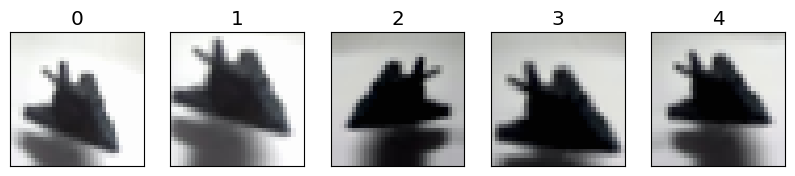

In [162]:
# datagenで，my_x_train_norm[0]から，M*N枚のデータを作成する
# my_x_train_norm[0]が様々に変形される
M=1
N=5
plt.figure(figsize=(N*2,M*2))
for index in range(M*N):
    cifar_img=plt.subplot(M,N,index+1)
    plt.imshow(datagen.flow(np.array([my_x_train_norm[0]]), batch_size=1)[0][0])
    plt.tick_params(left=False, labelleft=False)
    plt.tick_params(bottom=False, labelbottom=False)
    plt.title("{}".format(index))

plt.show()

## 水増しデータによるCNNモデルの学習

In [163]:
batch_size=64

#モデルの初期化
model = load_model('./CIFAR-10-notrained.keras')

#初期訓練（いきなり水増しデータで訓練すると，効率が悪い場合があるため）
history = model.fit(my_x_train_norm, my_y_train_onehot, epochs=20, validation_data=(x_test_org_norm, y_test_org_onehot))

# datagenでデータを変形しながら，my_x_train_normとmy_y_train_onehotの学習を行う．
# 正解率(accuracy)は，テスト用データ(x_test_org_norm, y_test_org_onehot)で評価する．
# 「過学習」を避けるために，正解率の評価には，訓練用データとは別の評価用データを使う．

history=model.fit(
    datagen.flow(my_x_train_norm, my_y_train_onehot, batch_size=batch_size),
    validation_data=(x_test_org_norm, y_test_org_onehot),
    steps_per_epoch=len(my_x_train_norm)/batch_size,
    epochs=20
)
# このノートブック中で最後に保存したモデルが提出する学習済みCNNモデルになる．
model.save(LEARNED_CNN_MODEL)

Epoch 1/20
344/344 [==============================] - 5s 11ms/step - loss: 2.2540 - accuracy: 0.1887 - val_loss: 2.2827 - val_accuracy: 0.1271
Epoch 2/20
344/344 [==============================] - 3s 9ms/step - loss: 2.0625 - accuracy: 0.2640 - val_loss: 2.0291 - val_accuracy: 0.2614
Epoch 3/20
344/344 [==============================] - 3s 10ms/step - loss: 1.9893 - accuracy: 0.2918 - val_loss: 1.9901 - val_accuracy: 0.2592
Epoch 4/20
344/344 [==============================] - 3s 8ms/step - loss: 1.9485 - accuracy: 0.3112 - val_loss: 1.9764 - val_accuracy: 0.2762
Epoch 5/20
344/344 [==============================] - 3s 9ms/step - loss: 1.8985 - accuracy: 0.3278 - val_loss: 1.8634 - val_accuracy: 0.3209
Epoch 6/20
344/344 [==============================] - 3s 9ms/step - loss: 1.8350 - accuracy: 0.3498 - val_loss: 1.7746 - val_accuracy: 0.3538
Epoch 7/20
344/344 [==============================] - 3s 9ms/step - loss: 1.7745 - accuracy: 0.3712 - val_loss: 1.7337 - val_accuracy: 0.3699
Epoc

## 学習時の損失関数と正解率の推移表示

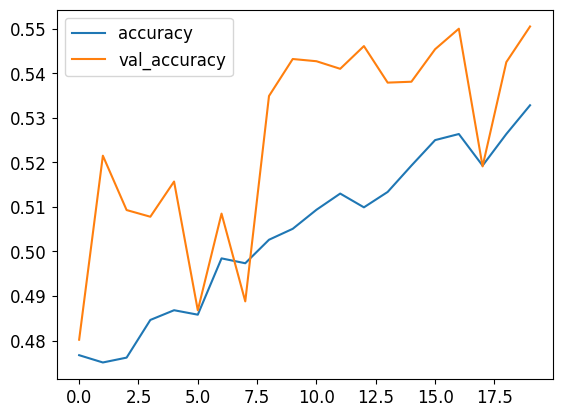

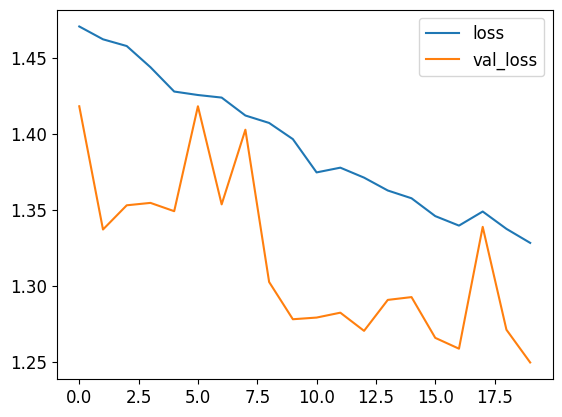

In [164]:
from pandas import DataFrame
# 学習に伴う正解率の変化
DataFrame({'accuracy':history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}).plot()
plt.show()

DataFrame({'loss':history.history['loss'], 'val_loss': history.history['val_loss']}).plot()
plt.show()

## 混同行列の表示

313/313 [==============================] - 1s 2ms/step
テストデータに対するconfusion_matrix


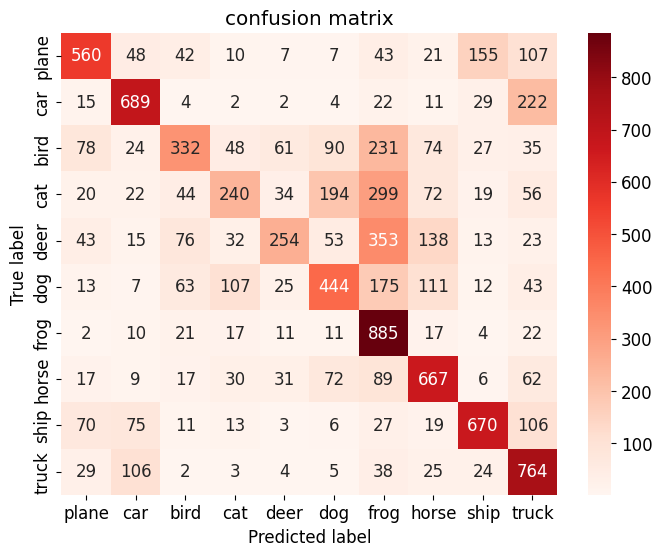

In [165]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 真のクラス
true_classes = np.argmax(y_test_org_onehot,1)
#print("true_classes=",true_classes)

# 予測したクラス
predict_classes = np.argmax(model.predict(x_test_org_norm), axis = -1)
#print("pred_classes=",predict_classes)

print("テストデータに対するconfusion_matrix")
cmx=confusion_matrix(true_classes, predict_classes)

# Trueにすると正規化 ->　値/(行の合計)　axis=1
normalize=False
if normalize:
    cmx = cmx.astype('float') / cmx.sum(axis=1)[:, np.newaxis]
    cmx_title="confusion matrix (normalized)"

    # 桁数指定
    cmx_fmt="1.2f"
else:
    cmx_title="confusion matrix"
    cmx_fmt="g"

cmx_labeled = pd.DataFrame(cmx, columns=classNames, index=classNames)

# 混同行列をcsvファイルに出力
# cmx_labeled.to_csv('cmx_labeled.csv')

# ヒートマップで表示
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cmx_labeled, annot=True, fmt=cmx_fmt, cmap='Reds')
ax.set_ylim(len(cmx_labeled), 0)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.title(cmx_title)
plt.rcParams["font.size"]=12
plt.show()

## コンテストでの正解率（重点学習クラスの重み付き）の計算

コンテストで正解率を評価する関数は以下の通りです．この関数には，CNNモデルのファイル名と，評価用データの番号を並べたファイル名と，各班に指定された重点分類クラスの番号を入力します．重点分類クラスのデータの正解には，３倍の重みがあります．

In [166]:
# modelFileNameのファイル名で，kerasのニューラルネットワークモデルのファイルを指定
# dataFileNameのファイル名で，評価用データの番号を並べたファイルを指定
# specialLabelには，重点分類番号を与える
def contest_demo(myModel, dataFileName, specialLabel):

    # ファイル読み込み
    dataIdxList = np.loadtxt(dataFileName, dtype=int).tolist()

    countAll = 0
    countCorrect = 0

    for index in dataIdxList:
        # 正解値
        classIdx=y_test_org[index][0]
        # 予測
        preds = myModel.predict(x_test_org_norm[index:index+1])
        maxpred = np.argmax(preds)

        # 点数
        point = 1 if (classIdx == maxpred) else 0

        # 倍率
        weight = 3 if (classIdx == specialLabel) else 1

        # 点数カウント
        countCorrect += (point*weight)
        countAll += weight

        print(' index:{}  answer:{}  prediction: {} point: {}'.format(index, classIdx, maxpred, point*weight))

    print (' total:{}'.format(float(countCorrect)/countAll))

コンテストでの評価デモの動かし方ですが，保存された認識モデルのファイル名，評価用データのファイル名と，重点学習クラスの番号を与えて動かします．

評価用データは，実際のコンテストでは教員から提供されますが，とりあえずテスト用に，0,1,2,...,99という番号のファイルを`'contestDataTest.txt'`として作ってみましょう．
以下のセルで作成されます．

In [167]:
#### USEFULL FOR GROUPWORK
# 学習済みモデルの優劣を調べるには毎回同じ評価データを使用して比較する
# ただし特定のデータに対して過学習してしまうことも考えられるため異なる評価データで試してみることも必要

# 最初の画像の番号(過学習が考えられる場合はここを変更)
START=0
# 評価する画像の枚数(すべての評価用データを使用すると時間がかかるため任意の枚数でよい)
NUM=100

START=min(START,10000-NUM)
numList=[]
for i in range(START,START+NUM):
    numList.append(i)
# ファイル出力
np.savetxt('contestDataTest.txt', numList, fmt='%d')

`'contestDataTest.txt'`に出力された番号を確認してみてください．
このファイルを用いて評価を行う場合，以下のように実行します．

In [168]:
# モデルの読み込み
mymodel = load_model(LEARNED_CNN_MODEL)

# 評価
contest_demo(mymodel, './contestDataTest.txt', int(CLASS_NO))

print('\n以下のモデルを評価しました．')
print('学習済みCNNモデル：' + LEARNED_CNN_MODEL + ' (' + current_dir + 'に保存)')

1/1 [==============================] - 0s 83ms/step
 index:0  answer:0  prediction: 8 point: 0
1/1 [==============================] - 0s 17ms/step
 index:1  answer:1  prediction: 1 point: 1
1/1 [==============================] - 0s 18ms/step
 index:2  answer:2  prediction: 6 point: 0
1/1 [==============================] - 0s 17ms/step
 index:3  answer:3  prediction: 3 point: 1
1/1 [==============================] - 0s 19ms/step
 index:4  answer:4  prediction: 0 point: 0
1/1 [==============================] - 0s 19ms/step
 index:5  answer:5  prediction: 6 point: 0
1/1 [==============================] - 0s 17ms/step
 index:6  answer:6  prediction: 6 point: 3
1/1 [==============================] - 0s 17ms/step
 index:7  answer:7  prediction: 7 point: 1
1/1 [==============================] - 0s 16ms/step
 index:8  answer:8  prediction: 1 point: 0
1/1 [==============================] - 0s 22ms/step
 index:9  answer:9  prediction: 9 point: 1
1/1 [==============================] - 0s 18ms/ste

In [169]:
import numpy as np
import IPython

rate = 48000
duration = 3.0
t = np.linspace(0., duration, int(rate*duration))
x = np.sin(2.0*np.pi*440.0*t)
IPython.display.Audio(x, rate=rate, autoplay=True)

## 終わりに

このノートブックは，グループワークに必要な作業のセルを集めて再構成したものです．このノートブックを修正して，実行することで，グループワークで必要なデータを集めることができます．

修正する場合には，元のファイルのバックアップを取っておきましょう．元の実装との性能比較を行う際に役立ちます．

このノートブックの内容を大きく修正しなくても，グループワークは可能ですが，学習済みのCNNモデルによる判定を，学習データの選定に使いたい，といったことがある場合には，一度学習を行った後で，学習データ選定のコードを実行したいかもしれません．そうした場合には，前のほうのセルの内容を，後の方にコピーして実行するなどの方法が必要です．
